In [1]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import urllib.request
import boto3
from smart_open import smart_open

from collections import Counter
from konlpy.tag import Kkma

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, Dense, GRU
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.python.client import device_lib


In [2]:
device_lib.list_local_devices()
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


False

In [3]:
total_data = pd.read_csv('./data/total_tokenized_V0.csv', encoding_errors='ignore', low_memory=False)

In [4]:
total_data

,Rating,Review,nouns,verbs,adjectives,exclamations
0,0,손님 놓치기 싫어서 지하층으로 손님을 받을거면 동일한 서비스를 제공하세요 그동안 ...,"['손님', '지하층', '손님', '거', '동일', '서비스', '제공', '앞...","['놓치', '싫', '받', '이', '가', '갈', '이', '하', '달라'...","['싫', '없']","['기', '어서', '을', '면', 'ㄴ', '세요', '었', '지만', 'ㅂ..."
1,1,김치찌개랑 계란말이 쨩,"['김치찌개', '계란', '말']",[],[],[]
2,1,맛있어요,[],['맛있'],['맛있'],['어요']
3,1,바빠요,[],['바쁘'],['바쁘'],['아요']
4,1,삼굡살이 너무맛나게먹엇쳐욤,[],"['맛나', '치']",['맛나'],"['게', '어요']"
...,...,...,...,...,...,...
10481,1,주차 시간 무료,"['주차', '시간', '무료']",[],[],[]
10482,1,케익이 맛있는 아티제,"['케익', '티']","['맛있', '아']",['맛있'],"['는', '아']"
10483,1,주차가돼요,['주차'],['되'],[],['어요']
10484,1,깔끔하고 저녁엔 회사 사람들이 빠져나가서 조용하고 좋네요,"['저녁', '회사', '사람']","['빠져나가', '좋']",['좋'],"['고', '서', '고', '네요']"


### 라벨이 NaN 제거

In [5]:
# total_data = total_data.dropna(subset=['rating'])

### 쓸 columns 합치기

In [5]:
import ast
# 문자열 형식의 리스트를 파이썬 리스트로 변환하는 함수
def convert_to_list(x):
    return [ast.literal_eval(token) for token in x]

In [36]:
selected_data = total_data[['Rating','nouns', 'verbs', 'adjectives', 'exclamations']]

selected_data['verbs'] = selected_data['verbs'].apply(lambda x: ''.join(x))
selected_data['adjectives'] = selected_data['adjectives'].apply(lambda x: ''.join(x))

C:\Users\USER\AppData\Local\Temp\ipykernel_9664\1479582050.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_data['verbs'] = selected_data['verbs'].apply(lambda x: ''.join(x))
C:\Users\USER\AppData\Local\Temp\ipykernel_9664\1479582050.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_data['adjectives'] = selected_data['adjectives'].apply(lambda x: ''.join(x))


### 긍정/부정 둘다 있는 토큰 찾기

In [37]:
data_0 = selected_data[selected_data['Rating'] == 0]
data_1 = selected_data[selected_data['Rating'] == 1]

list_0 = []
list_1 = []

for j in range(len(data_0)):
    for i in range(len(eval(data_0.iloc[j]['verbs']))):
        aa = eval(data_0.iloc[j]['verbs'])
        list_0.append(aa[i])

for j in range(len(data_1)):
    for i in range(len(eval(data_1.iloc[j]['verbs']))):
        aa = eval(data_1.iloc[j]['verbs'])
        list_1.append(aa[i])

In [38]:
# 두 리스트를 집합으로 변환
set_0 = set(list_0)
set_1 = set(list_1)

# 두 집합의 교집합을 구함
intersection = set_0.intersection(set_1)

# 교집합을 리스트로 변환
list_2 = list(intersection)

# 중복제거 각각 리스트
list_00 = list(set_0)
list_11 = list(set_1)


### 넣을 tokenized 정의

In [6]:
total_data['tokenized'] = None

In [7]:
total_data

,Rating,Review,nouns,verbs,adjectives,exclamations,tokenized
0,0,손님 놓치기 싫어서 지하층으로 손님을 받을거면 동일한 서비스를 제공하세요 그동안 ...,"['손님', '지하층', '손님', '거', '동일', '서비스', '제공', '앞...","['놓치', '싫', '받', '이', '가', '갈', '이', '하', '달라'...","['싫', '없']","['기', '어서', '을', '면', 'ㄴ', '세요', '었', '지만', 'ㅂ...",None
1,1,김치찌개랑 계란말이 쨩,"['김치찌개', '계란', '말']",[],[],[],None
2,1,맛있어요,[],['맛있'],['맛있'],['어요'],None
3,1,바빠요,[],['바쁘'],['바쁘'],['아요'],None
4,1,삼굡살이 너무맛나게먹엇쳐욤,[],"['맛나', '치']",['맛나'],"['게', '어요']",None
...,...,...,...,...,...,...,...
10481,1,주차 시간 무료,"['주차', '시간', '무료']",[],[],[],None
10482,1,케익이 맛있는 아티제,"['케익', '티']","['맛있', '아']",['맛있'],"['는', '아']",None
10483,1,주차가돼요,['주차'],['되'],[],['어요'],None
10484,1,깔끔하고 저녁엔 회사 사람들이 빠져나가서 조용하고 좋네요,"['저녁', '회사', '사람']","['빠져나가', '좋']",['좋'],"['고', '서', '고', '네요']",None


In [8]:
import ast

# 'verbs' 열의 문자열을 리스트로 변환하여 저장
total_data['verbs'] = total_data['verbs'].apply(lambda x: ast.literal_eval(x))

# 'adjectives' 열의 문자열을 리스트로 변환하여 저장
total_data['adjectives'] = total_data['adjectives'].apply(lambda x: ast.literal_eval(x))

# 'nouns' 열의 문자열을 리스트로 변환하여 저장
total_data['nouns'] = total_data['nouns'].apply(lambda x: ast.literal_eval(x))

# 'exclamations' 열의 문자열을 리스트로 변환하여 저장
total_data['exclamations'] = total_data['exclamations'].apply(lambda x: ast.literal_eval(x))

# 리스트를 합쳐서 'tokenized' 열에 할당
total_data['tokenized'] = total_data['verbs'] + total_data['adjectives'] + total_data['exclamations'] + total_data['nouns']


In [9]:
total_data['tokenized']

0        [놓치, 싫, 받, 이, 가, 갈, 이, 하, 달라, 하, 주, 없, 눈치보, 시키...
1                                            [김치찌개, 계란, 말]
2                                             [맛있, 맛있, 어요]
3                                             [바쁘, 바쁘, 아요]
4                                       [맛나, 치, 맛나, 게, 어요]
                               ...                        
10481                                         [주차, 시간, 무료]
10482                             [맛있, 아, 맛있, 는, 아, 케익, 티]
10483                                          [되, 어요, 주차]
10484                [빠져나가, 좋, 좋, 고, 서, 고, 네요, 저녁, 회사, 사람]
10485                        [크, 좋, 크, 좋, 고, 음, 삼성, 타워, ㅎ]
Name: tokenized, Length: 10486, dtype: object

In [10]:
# 'tokenized' 열에서 빈 리스트인 경우 NaN으로 처리
total_data['tokenized'] = total_data['tokenized'].apply(lambda x: np.nan if len(x) == 2 else x)

# NaN 값 제거
total_data.dropna(subset=['tokenized'], inplace=True)
total_data.reset_index(drop=True, inplace=True)

In [11]:
stopwords = ['도', '는', '다', '의', '가', '이', '은', '한', '에', '하', '고', '을', '를', '인', '듯', '과', '와', '네', '들', '듯', '지', '임', '게']
# stopwords.extend(list_2)

In [12]:
def preprocess_text(text):
    # 형태소 분석 및 불용어 처리
    tokens = [word for word in text if word not in stopwords]
    return tokens

In [24]:
from sklearn.model_selection import StratifiedKFold

# k-fold를 위한 변수 설정
k = 3  # k-fold의 k 값
skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)

# 데이터셋을 k-fold로 나누기
X = total_data['tokenized'].values
y = total_data['Rating'].values

best_model = None
best_accuracy = 0.0

# 각 fold에서 모델을 학습하고 평가하기
for train_index, test_index in skf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # 불용어 처리
    X_train = [preprocess_text(text) for text in X_train]
    X_test = [preprocess_text(text) for text in X_test]

    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(X_train)

    threshold = 2
    total_cnt = len(tokenizer.word_index)
    rare_cnt = 0
    total_freq = 0
    rare_freq = 0
    vocab_size = len(tokenizer.word_index) + 1  # 단어 인덱스 크기에 1을 더해줍니다.


    for key, value in tokenizer.word_counts.items():
        total_freq += value
        if value < threshold:
            rare_cnt += 1
            rare_freq += value
    
    tokenizer = Tokenizer(vocab_size, oov_token='OOV') 
    tokenizer.fit_on_texts(X_train)
    X_train = tokenizer.texts_to_sequences(X_train)
    X_test = tokenizer.texts_to_sequences(X_test)

    max_len = 80
    X_train = pad_sequences(X_train, maxlen=max_len)
    X_test = pad_sequences(X_test, maxlen=max_len)

    # 모델 정의
    embedding_dim = 400
    hidden_units = 128

    model = Sequential(name='sequential_5')
    model.add(Embedding(vocab_size, embedding_dim))
    model.add(GRU(hidden_units))
    model.add(Dense(1, activation='sigmoid'))

    # 모델 컴파일 및 학습
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
    mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

    model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
    history = model.fit(X_train, y_train, epochs=15, callbacks=[es, mc], batch_size=32, validation_split=0.2)

    # 평가
    loaded_model = load_model('best_model.h5')
    accuracy = loaded_model.evaluate(X_test, y_test)[1]
    print("\n 테스트 정확도: %.4f" % accuracy)

    # 최고의 모델 기록
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model = loaded_model

# 최종 모델 저장
best_model.save('./model/final_model_ALL.h5')
print("최종 모델이 저장되었습니다.")


Epoch 1/15
170/171 [============================>.] - ETA: 0s - loss: 0.1800 - acc: 0.9460
Epoch 1: val_acc improved from -inf to 0.96769, saving model to best_model.h5
171/171 [==============================] - 15s 74ms/step - loss: 0.1800 - acc: 0.9458 - val_loss: 0.1219 - val_acc: 0.9677
Epoch 2/15
  2/171 [..............................] - ETA: 10s - loss: 0.0807 - acc: 0.9844

c:\Users\USER\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


170/171 [============================>.] - ETA: 0s - loss: 0.1088 - acc: 0.9651
Epoch 2: val_acc improved from 0.96769 to 0.97504, saving model to best_model.h5
171/171 [==============================] - 13s 74ms/step - loss: 0.1087 - acc: 0.9651 - val_loss: 0.0757 - val_acc: 0.9750
Epoch 3/15
171/171 [==============================] - ETA: 0s - loss: 0.0820 - acc: 0.9739
Epoch 3: val_acc did not improve from 0.97504
171/171 [==============================] - 13s 75ms/step - loss: 0.0820 - acc: 0.9739 - val_loss: 0.0717 - val_acc: 0.9728
Epoch 4/15
171/171 [==============================] - ETA: 0s - loss: 0.0604 - acc: 0.9820
Epoch 4: val_acc did not improve from 0.97504
171/171 [==============================] - 12s 71ms/step - loss: 0.0604 - acc: 0.9820 - val_loss: 0.0932 - val_acc: 0.9728
Epoch 5/15
171/171 [==============================] - ETA: 0s - loss: 0.0506 - acc: 0.9857
Epoch 5: val_acc did not improve from 0.97504
171/171 [==============================] - 13s 78ms/step - 

In [25]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, None, 400)         2035200   
                                                                 
 gru_6 (GRU)                 (None, 128)               203520    
                                                                 
 dense_6 (Dense)             (None, 1)                 129       
                                                                 
Total params: 2238849 (8.54 MB)
Trainable params: 2238849 (8.54 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


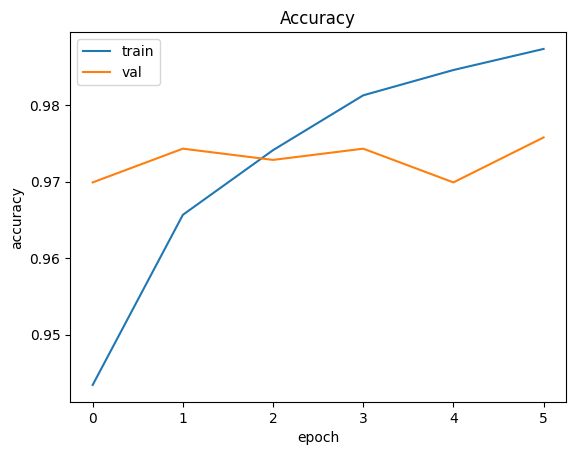

In [18]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

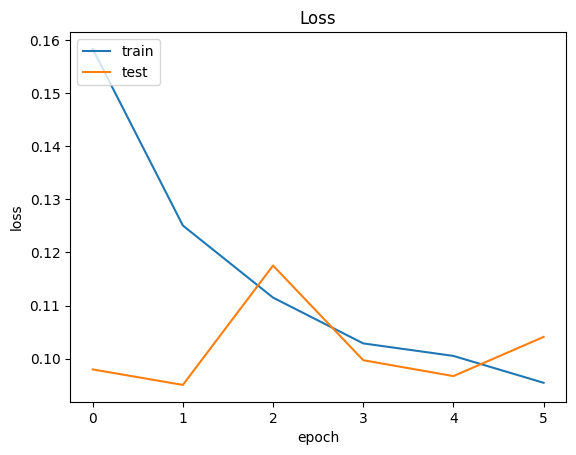

In [30]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [19]:
import pickle

# tokenizer 객체를 파일로 저장
def save_tokenizer(tokenizer, filepath):
    with open(filepath, 'wb') as f:
        pickle.dump(tokenizer, f, protocol=pickle.HIGHEST_PROTOCOL)

In [20]:
# 저장할 파일 경로 지정
tokenizer_filepath = './model/tokenizer_ALL.pkl'  # 저장할 파일 경로 및 파일 이름

# tokenizer 객체 저장
save_tokenizer(tokenizer, tokenizer_filepath)

In [21]:
tokenizer.index_word

{1: 'OOV',
 2: '좋',
 3: '맛있',
 4: '었',
 5: '어요',
 6: 'ㄴ',
 7: '습니다',
 8: '았',
 9: '어',
 10: '먹',
 11: '어서',
 12: '맛',
 13: '시',
 14: '는데',
 15: '음식',
 16: '분위기',
 17: 'ㅂ니다',
 18: '있',
 19: '친절',
 20: '네요',
 21: '아요',
 22: '많',
 23: 'ㄹ',
 24: '같',
 25: '아',
 26: '주',
 27: '없',
 28: '예약',
 29: '것',
 30: '괜찮',
 31: '오',
 32: '분',
 33: '직원',
 34: '아서',
 35: '방문',
 36: '만족',
 37: '서비스',
 38: '지만',
 39: '않',
 40: '나오',
 41: '기',
 42: '아쉽',
 43: '더',
 44: '자리',
 45: '곳',
 46: '면',
 47: '라',
 48: '파스타',
 49: '피자',
 50: '니',
 51: '보',
 52: '거',
 53: '나',
 54: '수',
 55: '넓',
 56: '때',
 57: '메뉴',
 58: 'ㅁ',
 59: '식사',
 60: '사람',
 61: '주문',
 62: '갈',
 63: '되',
 64: '시간',
 65: '가격',
 66: '편하',
 67: '공연',
 68: 'ㅎㅎ',
 69: '음',
 70: '강남',
 71: '그렇',
 72: '딸기',
 73: '싶',
 74: '네이버',
 75: '신선로',
 76: '집',
 77: '감사',
 78: '다음',
 79: '굿',
 80: 'ㄴ데',
 81: '크',
 82: '맛나',
 83: '최고',
 84: '겠',
 85: '비싸',
 86: '알',
 87: '구요',
 88: '받',
 89: '구',
 90: '늦',
 91: '아니',
 92: '매장',
 93: '생각',
 94: '친구',
 95: '이용',


In [22]:
total_data.to_csv('./data/tokenized_data_ALL.csv', encoding='utf-8-sig')

In [23]:
# 저장할 파일 경로 지정
stopwords_filepath = './model/stopwords_ALL.pkl'  # 저장할 파일 경로 및 파일 이름

# tokenizer 객체 저장
save_tokenizer(stopwords, stopwords_filepath)